## Connect to google drive to import the datasets and download the relevant files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')     #using google drive to import the file

import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## *Function* to load the file of a corresponding file name from the google drive.
   The corpus contains lots of things which are not of our interest.
   Read file and discard things that are of not interest to us.


```
    :param: filename
    :return: label, sentencesX, sentencesY
    :return type: list of bools, list of sentence, list of sentence
    :param sentence type : string
```



In [ ]:
import os
#Read the file and store the labels and respective sentences
# in different vectors by splitting each line into the 3 different parts

def dataLoader(filename):
    if not os.path.exists(filename):
        raise ValueError("{} file does not exist.")

    # Read file and split into lines
    text = open(filename, mode='r', encoding='utf8').read().lower().splitlines()

    labels, sentence1, sentence2 = [], [], []
    for line in text[1:]:
        label, _, _, s1, s2 = line.split("\t")

        labels.append(label)
        sentence1.append(s1)
        sentence2.append(s2)

    labels = list(map(int, labels))

    return labels, sentence1, sentence2

## Perform preprocessing to convert the lists using stop words and lemmatization

In [ ]:
from collections import Counter
import os
from bisect import bisect_left

import nltk
from nltk import WordPunctTokenizer, PunktSentenceTokenizer, PorterStemmer
from nltk.tokenize import word_tokenize

sent_tokenizer = PunktSentenceTokenizer()
word_tokenizer = WordPunctTokenizer()
stemmer = PorterStemmer()


def in_sorted_list(lists, item):
    """
    Returns True if the item is in the sorted list else False
    """
    index = bisect_left(lists, item)
    if lists[min(index, len(lists) - 1)] == item:
        return True
    else:
        return False


def is_stopwords(stopwords, word):
    """
    Returns True if the word is in thesorted list of stopwords else False
    """
    return in_sorted_list(stopwords, word)


class Preprocess:
    def __init__(self, vocab_size=None,
                 remove_stopwords=True):
        self.vocab_size = vocab_size
        self.stopwords = open("/root/nltk_data/corpora/stopwords/english", mode='r', encoding='utf8').readlines()
        self.remove_stopwords = remove_stopwords


    def build_vocab(self, text, stem=True):
        """
        :parameter vocab_size : size of vocabulary to consider other words will be replaced with UNK
            total_vocab_size = vocab_size + 1
            vocab_size of -1 means consider all the words
        :parameter text : text from which to build vocabulary
        type string
        """
        text = text.lower()
        self.words = word_tokenizer.tokenize(text)

        all_vocab = set(self.words)

        if stem:
            lemmatized_vocab = [stemmer.stem(word) for word in all_vocab]
            self.lemmatized_dict = dict(zip(all_vocab, lemmatized_vocab))
            self.words = [self.lemmatized_dict[word] for word in self.words]

        word_counter = Counter(self.words)

        vocab_size = self.vocab_size
        if not self.vocab_size:
            vocab_size = len(word_counter)
        vocab = word_counter.most_common(vocab_size)

        self.vocab = set([word for word, count in vocab])

    def preprocess(self, sentences):
        processed_sentences = []
        for sentence in sentences:
            sentence = word_tokenizer.tokenize(sentence)
            sentence = [word for word in sentence if not is_stopwords(self.stopwords, word)]

            sentence = [stemmer.stem(word) for word in sentence]

            if self.vocab_size:
                sentence = [word if word in self.vocab else 'unk' for word in sentence]

            sentence = " ".join(sentence)
            processed_sentences.append(sentence)
        return processed_sentences


In [ ]:
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

class ParaphraseDetector:
    def __init__(self, stem=True, vocab_size=8000, noise_percent=10,noise_dist=0):
        """
        :parameter distance : cosine
        Steps:
        For given filenames if processed_filename does not exist,
            load unprocessed data and process it
            Save processed data so that you don't have to preprocess all the time
        else load processed data
        """

        train_filename = "drive/MyDrive/MSRParaphraseCorpus/msr_paraphrase_train.txt"
        test_filename = "drive/MyDrive/MSRParaphraseCorpus/msr_paraphrase_test.txt"

        # train_filename = "drive/MyDrive/msr_paraphrase_train.txt"
        # test_filename = "drive/MyDrive/msr_paraphrase_test.txt"

        self.train_labels, self.train_pair1, self.train_pair2 = dataLoader(train_filename)
        self.test_labels, self.test_pair1, self.test_pair2 = dataLoader(test_filename)


        text = self.train_pair1 + self.train_pair2
        text = " ".join(text)

        self.preprocess = Preprocess(vocab_size=vocab_size)
        self.preprocess.build_vocab(text, stem=stem)

        self.train_pair1 = self.preprocess.preprocess(self.train_pair1)
        self.train_pair2 = self.preprocess.preprocess(self.train_pair2)

        self.test_pair1 = self.preprocess.preprocess(self.test_pair1)
        self.test_pair2 = self.preprocess.preprocess(self.test_pair2)

        self.train_labels = self.train_labels
        self.test_labels = self.test_labels


        for idx in self.generate_noise(percent=noise_percent,dist=noise_dist):
          self.train_labels[idx] = 1 - self.train_labels[idx]

    def generate_noise(self,percent=0,dist=0):
        if(dist==0):
          one_indexes=[]
          for x in range(len(self.train_labels)):
            if(self.train_labels[x]==1):
              one_indexes.append(x)
          noise_indexes = random.sample(range(len(one_indexes)), int(percent/100 * len(one_indexes)))
          return noise_indexes
        elif dist==1:
          one_indexes=[]
          corpus = self.train_pair1 + self.train_pair2

          self.vectorizer = TfidfVectorizer().fit(corpus)  # It requires list of strings (sentences) not list of list
          # print("tfidf Vocab  size : ", self.vectorizer.vocabulary_.__len__())


          train_vec1 = self.vectorizer.transform(self.train_pair1).todense()
          train_vec2 = self.vectorizer.transform(self.train_pair2).todense()
          cosine_similarities = [np.round(cosine_similarity(vec_1, vec_2).item(),2) for vec_1, vec_2 in zip(train_vec1,train_vec2)]

          for i in range(1,11):
            indexes=[]
            for j in range(len(cosine_similarities)):
              if((i-1)/10<cosine_similarities[j]<i/10 and self.train_labels[j]==1):
                indexes.append(j)
            one_indexes.append(indexes)
          noise_indexes=[]
          for i in range(len(one_indexes)):
              noise_indexes =noise_indexes+ random.sample(one_indexes[i], int((10-i)/10 * len(one_indexes[i])))

          return noise_indexes
        else:
          one_indexes=[]
          corpus = self.train_pair1 + self.train_pair2

          self.vectorizer = TfidfVectorizer().fit(corpus)  # It requires list of strings (sentences) not list of list
          # print("tfidf Vocab  size : ", self.vectorizer.vocabulary_.__len__())


          train_vec1 = self.vectorizer.transform(self.train_pair1).todense()
          train_vec2 = self.vectorizer.transform(self.train_pair2).todense()
          cosine_similarities = [np.round(cosine_similarity(vec_1, vec_2).item(),2) for vec_1, vec_2 in zip(train_vec1,train_vec2)]

          for i in range(1,11):
            indexes=[]
            for j in range(len(cosine_similarities)):
              if((i-1)/10<cosine_similarities[j]<i/10 and self.train_labels[j]==1):
                indexes.append(j)
            one_indexes.append(indexes)
          noise_indexes=[]
          for i in range(len(one_indexes)):
              noise_indexes =noise_indexes+ random.sample(one_indexes[i], int((10-i)/10 * len(one_indexes[i])))
          zero_indexes=[]
          for i in range(1,11):
            indexes=[]
            for j in range(len(cosine_similarities)):
              if((i-1)/10<cosine_similarities[j]<i/10 and self.train_labels[j]==0):
                indexes.append(j)
            zero_indexes.append(indexes)
          for i in range(len(one_indexes)):
              noise_indexes =noise_indexes+ random.sample(zero_indexes[i], int((i-1)/10 * len(zero_indexes[i])))
          return noise_indexes


    def compare(self):

        corpus = self.train_pair1 + self.train_pair2

        self.vectorizer = TfidfVectorizer().fit(corpus)  # It requires list of strings (sentences) not list of list
        # print("tfidf Vocab  size : ", self.vectorizer.vocabulary_.__len__())

        # vectors in high dimension
        train_vec1 = self.vectorizer.transform(self.train_pair1).todense()
        train_vec2 = self.vectorizer.transform(self.train_pair2).todense()
        test_vec1 = self.vectorizer.transform(self.test_pair1).todense()
        test_vec2 = self.vectorizer.transform(self.test_pair2).todense()

        cosine_similarities = [np.round(cosine_similarity(vec_1, vec_2).item(),2) for vec_1, vec_2 in zip(train_vec1,train_vec2)]
        cosine_similarities_ones=[]
        cosine_similarities_zeroes=[]
        indexes = []
        sorted_cosine_similarities = sorted(cosine_similarities)
        y = 0
        sorted_labels = [(cosine_similarities[i], self.train_labels[i]) for i in range(0, len(cosine_similarities))]
        sorted_labels.sort(key=lambda y: y[0])

        min_y_cosine = 10000000000
        min_y = 1000000000

        for x in range(len(self.train_labels)):
            if(sorted_labels[x][1]==1):
              # cosine_similarities_ones.append(cosine_similarities[x])
              y+=1
            if(sorted_labels[x][1]==0):
              y-=1
              # cosine_similarities_zeroes.append(cosine_similarities[x])
            # if ((y <= min_y) and (sorted_labels[x][0]!=sorted_labels[x+1][0])):
            if ((y <= min_y) and  ( sorted_labels[x][0] >= 0.5 ) and (x==len(self.train_labels) or (sorted_labels[x][0]!=sorted_labels[(x+1) % len(self.train_labels)][0]))):
              min_y = y
              min_y_cosine = sorted_labels[x][0]
            indexes.append(y)

        # print("Min Y: ",min_y)
        print("Min Cosine: ",min_y_cosine)
        # plt.plot(sorted(cosine_similarities_ones),range(len(cosine_similarities_ones)),label="Cosine similarities of ones")
        # plt.plot(sorted(cosine_similarities_zeroes),range(len(cosine_similarities_zeroes)),label="Cosine similariteis of zeroes")
        plt.figure()
        # poly = np.polyfit(sorted_cosine_similarities,indexes,)
        # poly_y = np.poly1d(poly)(sorted_cosine_similarities)
        # plt.plot(sorted_cosine_similarities,poly_y)

        plt.plot(sorted_cosine_similarities,indexes,label="")
        plt.xlabel("cosine similarity")
        plt.ylabel("Cummulative difference between 1s and 0s")
        plt.legend()
        plt.show()
        if False:
          for idx in random.sample(range(len(self.train_pair1)),10):
            print("Sentence1: ", self.train_pair1[idx])
            print("Sentence2: ", self.train_pair2[idx])
            print("Cosine Similarity: ",cosine_similarities[idx])
            print("Label: ",self.train_labels[idx])
            print("---------------------------")

        optimum_thresh=0.500
        best_score=0

        for threshold in np.arange(0.50,1.00,0.001):
            threshold = np.round(threshold,3)
            predicted = [(similarity) >= threshold for similarity in cosine_similarities]
            match_success = [pred == label for pred, label in zip(predicted, self.train_labels)]
            if(sum(match_success)>best_score):
              optimum_thresh=threshold
              best_score=sum(match_success)
            # print(np.round(threshold,2),best_score)
        print("Optimum Threshold: ", optimum_thresh)
        accuracy,f1_score = self.accuracy(test_vec1, test_vec2,self.test_labels, optimum_thresh)
        print("Accuracy: ", accuracy)
        print("F1-score", f1_score)

# Function to calculate accuracy and F1-Score
# The parameters on the basis o=f which we have judged our model

    def accuracy(self, tfidf_1, tfidf_2, labels, thresh=0.6):

        scores = [cosine_similarity(vec_1, vec_2).item() for vec_1, vec_2 in
                  zip(tfidf_1, tfidf_2)]

        predicted = [score > thresh for score in scores]
        accuracy = [pred == label for pred, label in zip(predicted, labels)]
        accuracy = sum(accuracy) / len(accuracy)
        true_positive, true_negative, false_positive, false_negative = 0, 0, 0, 0
        for ground_truth, estimated in zip(labels, predicted):
            if ground_truth == True:
                if estimated == True:
                    true_positive += 1
                else:
                    false_negative += 1
            else:
                if estimated == False:
                    true_negative += 1
                else:
                    false_positive += 1
        eps = 1e-100
        precision = true_positive / (true_positive + false_positive + eps)
        recall = true_positive / (true_positive + false_negative + eps)
        f1_score = 2 * (precision * recall) / (precision + recall + eps)

        return accuracy,f1_score


## Ouput With supporting Graphs



Vocab Size :  8000 


              Random Noise                 
-------------------------------------------
Noise Percentage : 0


Min Cosine:  0.6


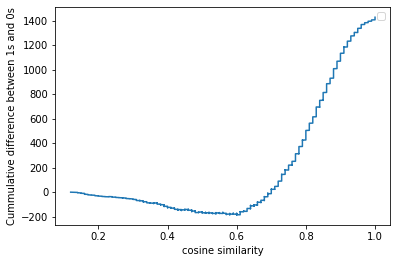

Optimum Threshold:  0.601
Accuracy:  0.7101449275362319
F1-score 0.7884940778341794

Noise Percentage : 5


Min Cosine:  0.53


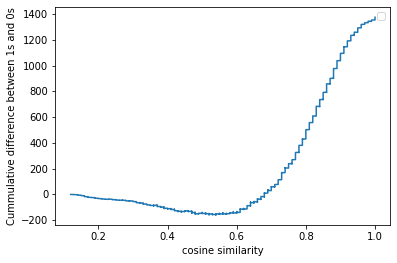

Optimum Threshold:  0.531
Accuracy:  0.7246376811594203
F1-score 0.8143806174286831

Noise Percentage : 10


Min Cosine:  0.6


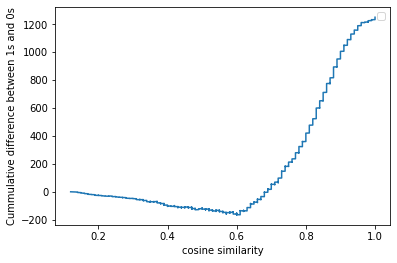

Optimum Threshold:  0.601
Accuracy:  0.7101449275362319
F1-score 0.7884940778341794

Noise Percentage : 15


Min Cosine:  0.57


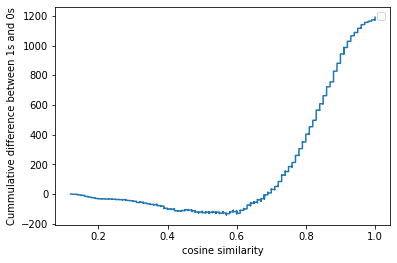

Optimum Threshold:  0.571
Accuracy:  0.7176811594202899
F1-score 0.8013055895552836

Noise Percentage : 20


Min Cosine:  0.53


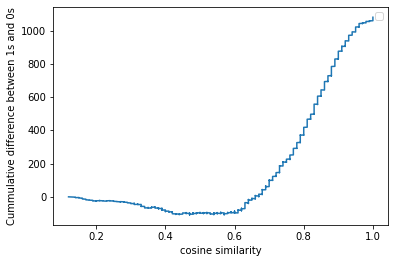

Optimum Threshold:  0.531
Accuracy:  0.7246376811594203
F1-score 0.8143806174286831

Noise Percentage : 25


Min Cosine:  0.57


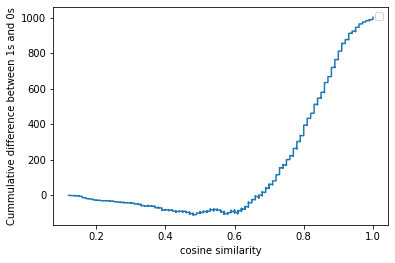

Optimum Threshold:  0.571
Accuracy:  0.7176811594202899
F1-score 0.8013055895552836

Noise Percentage : 30


Min Cosine:  0.57


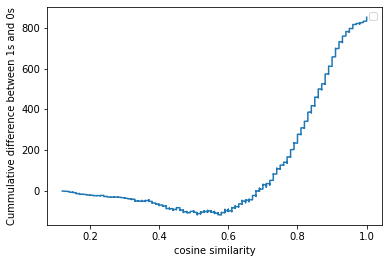

Optimum Threshold:  0.571
Accuracy:  0.7176811594202899
F1-score 0.8013055895552836

Noise Percentage : 35


Min Cosine:  0.6


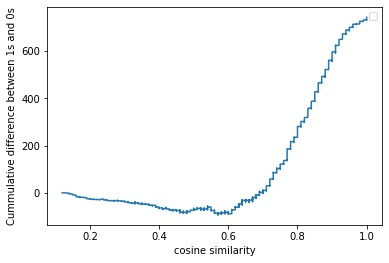

Optimum Threshold:  0.571
Accuracy:  0.7176811594202899
F1-score 0.8013055895552836

Noise Percentage : 40


Min Cosine:  0.56


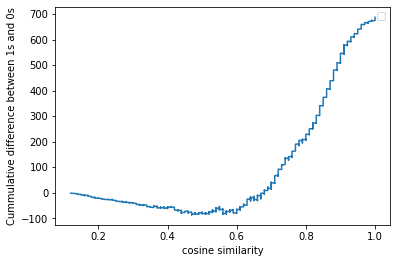

Optimum Threshold:  0.501
Accuracy:  0.7205797101449275
F1-score 0.8164508758568165

Noise Percentage : 45


Min Cosine:  0.53


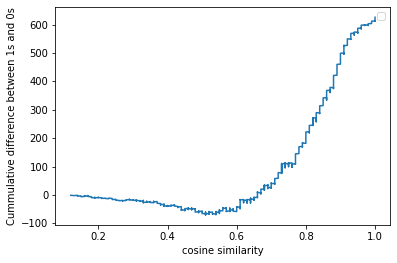

Optimum Threshold:  0.511
Accuracy:  0.7188405797101449
F1-score 0.8139624088991178

Noise Percentage : 50


Min Cosine:  0.6


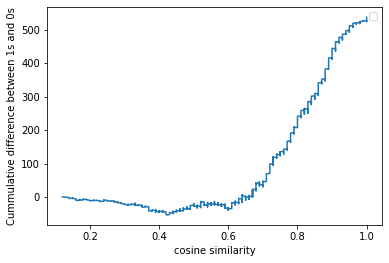

Optimum Threshold:  0.601
Accuracy:  0.7101449275362319
F1-score 0.7884940778341794

Noise Percentage : 55


Min Cosine:  0.5


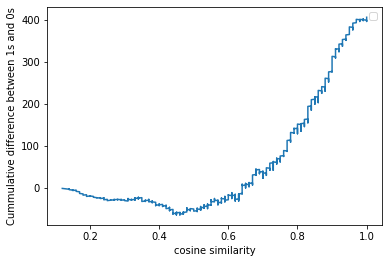

Optimum Threshold:  0.501
Accuracy:  0.7205797101449275
F1-score 0.8164508758568165

Noise Percentage : 60


Min Cosine:  0.5


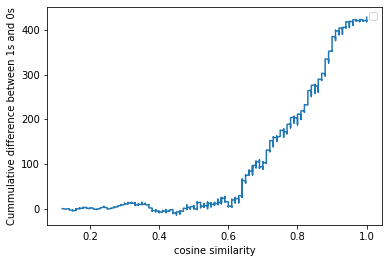

Optimum Threshold:  0.501
Accuracy:  0.7205797101449275
F1-score 0.8164508758568165

Noise Percentage : 65


Min Cosine:  0.6


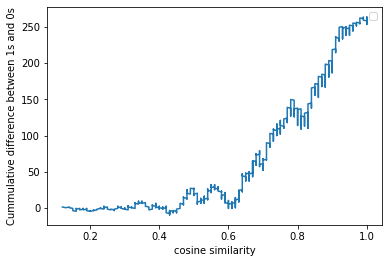

Optimum Threshold:  0.601
Accuracy:  0.7101449275362319
F1-score 0.7884940778341794

Noise Percentage : 70


Min Cosine:  0.52


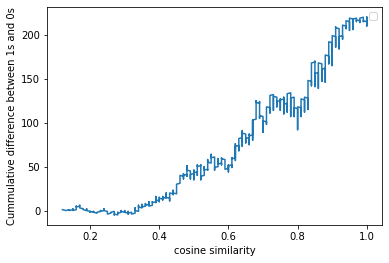

Optimum Threshold:  0.521
Accuracy:  0.721159420289855
F1-score 0.8140703517587939

Noise Percentage : 75


Min Cosine:  0.85


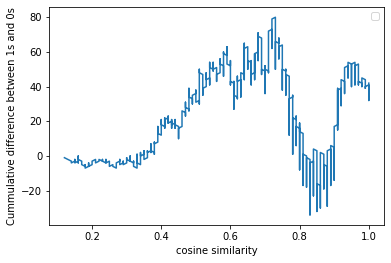

Optimum Threshold:  0.851
Accuracy:  0.4852173913043478
F1-score 0.3884297520661157

Noise Percentage : 80


Min Cosine:  0.88


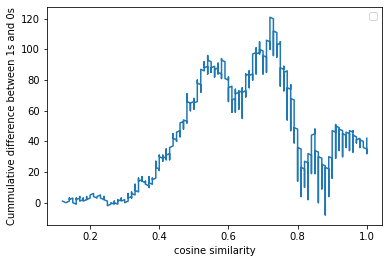

Optimum Threshold:  0.811
Accuracy:  0.5402898550724637
F1-score 0.5009439899307742

Noise Percentage : 85


Min Cosine:  1.0


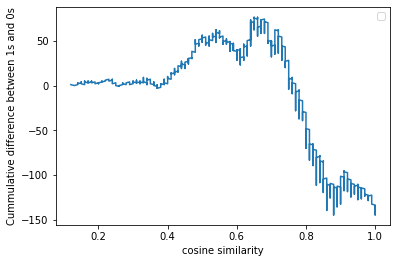

Optimum Threshold:  0.991
Accuracy:  0.3408695652173913
F1-score 0.017286084701815037

Noise Percentage : 90


Min Cosine:  0.99


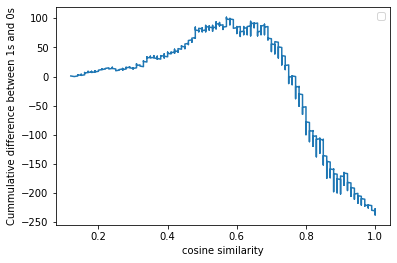

Optimum Threshold:  0.991
Accuracy:  0.3408695652173913
F1-score 0.017286084701815037

Noise Percentage : 95


Min Cosine:  1.0


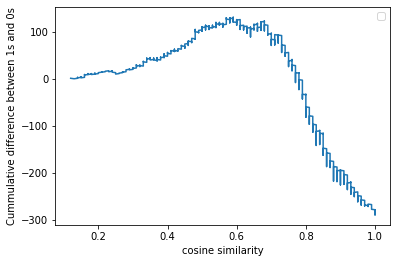

Optimum Threshold:  0.991
Accuracy:  0.3408695652173913
F1-score 0.017286084701815037


              Realistic Noise                 
-------------------------------------------
Stats for linear decreasing noise of ones


Min Cosine:  0.69


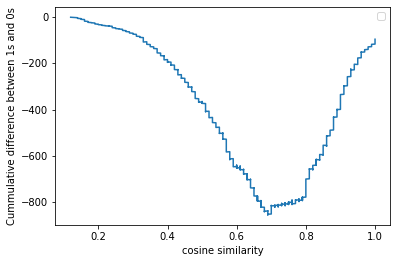

Optimum Threshold:  0.691
Accuracy:  0.673623188405797
F1-score 0.7276245766811804

Stats for linear decreasing noise of ones and linear increasing noise of zeroes


Min Cosine:  0.6


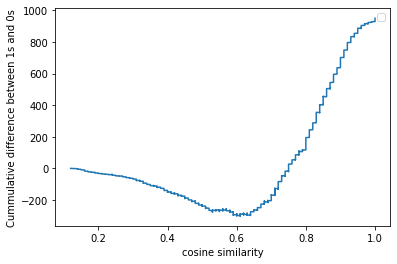

Optimum Threshold:  0.601
Accuracy:  0.7101449275362319
F1-score 0.7884940778341794


In [ ]:
vocab_size = 8000
noise_percents = np.arange(0,100,5)
import warnings
warnings.filterwarnings("ignore")
print("Vocab Size : ", vocab_size, "\n")

print()
print("              Random Noise                 ")
print("-------------------------------------------")
for noise_percent in noise_percents:
  print("Noise Percentage : {}".format(noise_percent))
  cp = ParaphraseDetector(vocab_size=vocab_size, noise_percent=noise_percent)
  cp.compare()
  print()

print()
print("              Realistic Noise                 ")
print("-------------------------------------------")
print("Stats for linear decreasing noise of ones")
cp=ParaphraseDetector(vocab_size=vocab_size,noise_percent=0,noise_dist=1)
cp.compare()
print()
print("Stats for linear decreasing noise of ones and linear increasing noise of zeroes")
cp=ParaphraseDetector(vocab_size=vocab_size,noise_percent=0,noise_dist=2)
cp.compare()